In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [5]:
import pickle
from copy import deepcopy
from pathlib import Path

import gurobipy
from gurobipy import GRB
import dgl
import numpy as np
import torch
import matplotlib.pyplot as plt

from src.problem import get_model, get_soc, load_instance
from src.dataset import InstanceEarlyFixingDataset
from src.net import InstanceGCN
from src.utils import load_from_wandb

In [6]:
instances = list(Path('../data/raw').glob('97_9*.jl'))[-2:]  # test instances only

with open('../97_9_opts.pkl', 'rb') as f:
    opts = pickle.load(f)

net = InstanceGCN(2, readout_op=None)
net = load_from_wandb(net, 'f6ceqpse', 'sat-gnn', 'model_best')
net.eval()

opts = [opts[i.name]['sol'] for i in instances]
ds = InstanceEarlyFixingDataset(
    [load_instance(i) for i in instances],
    opts,
    samples_per_problem=10,
)
g1 = ds.gs[0]
g2 = ds.gs[1]

x1_opt = torch.from_numpy(opts[0])
x2_opt = torch.from_numpy(opts[1])

g1, g2

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-14


(Graph(num_nodes={'con': 5872, 'soc': 291, 'var': 1746},
       num_edges={('con', 'c2s', 'soc'): 775, ('con', 'c2v', 'var'): 58784, ('soc', 's2c', 'con'): 775, ('var', 'v2c', 'con'): 58784},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]),
 Graph(num_nodes={'con': 5957, 'soc': 291, 'var': 1746},
       num_edges={('con', 'c2s', 'soc'): 775, ('con', 'c2v', 'var'): 54107, ('soc', 's2c', 'con'): 775, ('var', 'v2c', 'con'): 54107},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]))

In [7]:
instances

[PosixPath('../data/raw/97_9_5.jl'), PosixPath('../data/raw/97_9_1.jl')]

In [12]:
def create_batch(g, xs):
    g_batch = list()
    for x in xs:
        g_ = deepcopy(g)
        curr_feats = g_.nodes['var'].data['x']
        g_.nodes['var'].data['x'] = torch.hstack((
            # unsqueeze features dimension, if necessary
            curr_feats.view(curr_feats.shape[0],-1),
            x.view(x.shape[-1],-1),
        ))
        g_batch.append(g_)
    return dgl.batch(g_batch)

x1s = torch.randint(0, 2, (10, 1746))
g1_batch = create_batch(g1, x1s)

x2s = torch.randint(0, 2, (10, 1746))
g2_batch = create_batch(g2, x2s)

g1_batch, g2_batch

(Graph(num_nodes={'con': 58720, 'soc': 2910, 'var': 17460},
       num_edges={('con', 'c2s', 'soc'): 7750, ('con', 'c2v', 'var'): 587840, ('soc', 's2c', 'con'): 7750, ('var', 'v2c', 'con'): 587840},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]),
 Graph(num_nodes={'con': 59570, 'soc': 2910, 'var': 17460},
       num_edges={('con', 'c2s', 'soc'): 7750, ('con', 'c2v', 'var'): 541070, ('soc', 's2c', 'con'): 7750, ('var', 'v2c', 'con'): 541070},
       metagraph=[('con', 'soc', 'c2s'), ('con', 'var', 'c2v'), ('soc', 'con', 's2c'), ('var', 'con', 'v2c')]))

[0, 106, 756, 857, 954, 1746] [0, tensor(0.9906), tensor(0.9749), tensor(0.9697), tensor(0.9654), tensor(0.8139)]
[11, 69, 688, 857, 958, 1746] [tensor(1.), tensor(0.9855), tensor(0.9666), tensor(0.9615), tensor(0.9447), tensor(0.8190)]


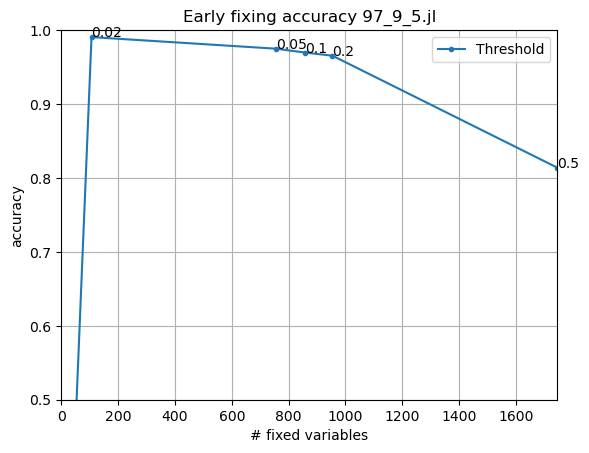

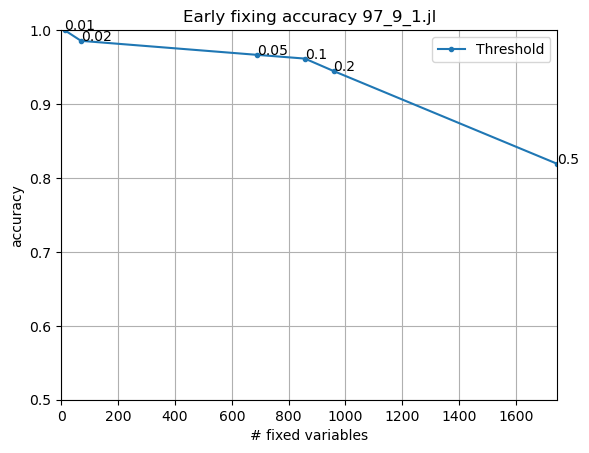

In [13]:
def get_ef_accuracy(g_batch, xs, x_opt, name=None, plot=True):
    with torch.no_grad():
        y_hat = torch.sigmoid(net(g_batch))

    y_flip = 1 - y_hat
    x_hat = (xs - y_flip).abs()  # prob. of the predicted optimal solution
    err = (x_hat - x_opt).abs()

    thresholds = [.01, .02, .05, .1, .2, .5]

    accs = list()
    ns = list()
    for thresh in thresholds:
        most_certain = (x_hat.mean(0) < thresh) | (x_hat.mean(0) >= 1 - thresh)
        if most_certain.sum() == 0:
            accs.append(0)
            ns.append(0)
            continue
        fixed_x_hat = (x_hat.mean(0)[most_certain] > .5).to(x_opt)
        fixed_x_opt = x_opt[most_certain]

        acc = (fixed_x_hat == fixed_x_opt).sum() / fixed_x_opt.shape[0]

        accs.append(acc)
        ns.append(fixed_x_hat.shape[0])

    if plot:
        fig, ax = plt.subplots()
        ax.plot(ns, accs, '.-', label='Threshold')
        ax.set_xlim((0, x_opt.shape[0]))
        ax.set_ylim((.5, 1.))
        ax.grid()
        ax.legend()

        ax.set_title('Early fixing accuracy '+str(name))
        ax.set_xlabel('# fixed variables')
        ax.set_ylabel('accuracy')

        for i, thresh in enumerate(thresholds):
            ax.annotate(thresh, (ns[i], accs[i]))

        fig.show()
    
    return thresholds, ns, accs

_, n1s, acc1s = get_ef_accuracy(g1_batch, x1s, x1_opt, name=instances[0].name)
print(n1s, acc1s)
_, n2s, acc2s = get_ef_accuracy(g2_batch, x2s, x2_opt, name=instances[1].name)
print(n2s, acc2s)

### Early Fixing Time Reduction

In [53]:
instances

[PosixPath('../data/raw/97_9_5.jl'), PosixPath('../data/raw/97_9_1.jl')]

In [57]:
instance = instances[0]
print(instance.name)
model = get_model(list(range(9)), instance, coupling=True)
# model.Params.LogToConsole = 1
# model.setParam('TimeLimit', 5 * 60)
model.setParam('MIPGap', .05)
model.update()
model.optimize()
print(model.Runtime)
print(model.ObjVal)

instance = instances[1]
print(instance.name)
model = get_model(list(range(9)), instance, coupling=True)
# model.Params.LogToConsole = 1
# model.setParam('TimeLimit', 5 * 60)
model.setParam('MIPGap', .05)
model.update()
model.optimize()
print(model.Runtime)
print(model.ObjVal)

97_9_5.jl
67.37420201301575
2471.0
97_9_1.jl
19.776083946228027
2493.0


In [60]:
g_batch = g1_batch
xs = x1s
x_opt = x1_opt
model = get_model(list(range(9)), instances[0], coupling=True)

vars_names = np.core.defchararray.array([v.getAttr(GRB.Attr.VarName) for v in model.getVars()])
vars_names = vars_names[(vars_names.find('x(') >= 0) | (vars_names.find('phi(') >= 0)]

with torch.no_grad():
    y_hat = torch.sigmoid(net(g_batch))

y_flip = 1 - y_hat
x_hat = (xs - y_flip).abs()  # prob. of the predicted optimal solution
err = (x_hat - x_opt).abs()

thresholds = [.01, .02, .05, .1, .2, .5]

ns = list()
runtimes = list()
objs = list()
for thresh in thresholds:
    most_certain = (x_hat.mean(0) < thresh) | (x_hat.mean(0) >= 1 - thresh)
    if most_certain.sum() == 0:
        ns.append(0)
        runtimes.append(-1)
        objs.append(-1)
        continue
    fixed_x_hat = (x_hat.mean(0)[most_certain] > .5).to(x_opt)
    fixed_x_opt = x_opt[most_certain]

    ns.append(fixed_x_hat.shape[0])

    fixed_vars_names = vars_names[most_certain]

    # fix variables
    model_ = model.copy()
    for fixed_var_name, fixed_var_X in zip(fixed_vars_names, fixed_x_hat):
        model_.getVarByName(fixed_var_name).lb = fixed_var_X
        model_.getVarByName(fixed_var_name).ub = fixed_var_X
    model.setParam('MIPGap', .05)
    
    model_.update()
    model_.optimize()
    runtimes.append(model_.Runtime)
    objs.append(model_.ObjVal)
    break

# fig, ax = plt.subplots()
# ax.plot(ns, accs, '.-', label='Threshold')
# ax.set_xlim((0, x_opt.shape[0]))
# ax.set_ylim((.5, 1.))
# ax.grid()
# ax.legend()

# ax.set_title('Early fixing accuracy '+'asdfadsf')
# ax.set_xlabel('# fixed variables')
# ax.set_ylabel('accuracy')

# # for i, thresh in enumerate(thresholds):
# #     ax.annotate(thresh, (ns[i], accs[i]))

# fig.show()

In [45]:
model = get_model(list(range(9)), instances[1], coupling=True)
model.Params.LogToConsole = 1
# model.setParam('TimeLimit', 5 * 60)
model.setParam('MIPGap', .02)
model.update()

vars_names = np.core.defchararray.array([v.getAttr(GRB.Attr.VarName) for v in model.getVars()])
vars_names = vars_names[(vars_names.find('x(') >= 0) | (vars_names.find('phi(') >= 0)]

thresh = .02
most_certain = (x_hat.mean(0) < thresh) | (x_hat.mean(0) >= 1 - thresh)

fixed_x_hat = (x_hat.mean(0)[most_certain] > .5).to(x_opt)
fixed_x_opt = x_opt[most_certain]

fixed_vars_names = vars_names[most_certain]

# fix variables
for fixed_var_name, fixed_var_X in zip(fixed_vars_names, fixed_x_hat):
    model.getVarByName(fixed_var_name).lb = fixed_var_X
    model.getVarByName(fixed_var_name).ub = fixed_var_X

Set parameter LogToConsole to value 1
Set parameter MIPGap to value 0.02


chararray(['phi(1,1)', 'phi(1,2)', 'phi(1,3)', 'phi(1,4)', 'phi(1,5)',
           'phi(1,6)', 'phi(1,7)', 'phi(1,8)', 'phi(1,9)', 'phi(1,10)',
           'phi(1,11)', 'phi(1,12)', 'phi(1,13)', 'phi(1,82)',
           'phi(1,83)', 'phi(1,84)', 'phi(1,85)', 'phi(1,86)',
           'phi(1,87)', 'phi(1,88)', 'phi(1,89)', 'phi(1,90)',
           'phi(1,91)', 'phi(1,92)', 'phi(1,93)', 'phi(1,94)', 'phi(2,3)',
           'phi(2,4)', 'phi(2,5)', 'phi(2,6)', 'phi(2,7)', 'phi(2,8)',
           'phi(2,89)', 'phi(2,90)', 'phi(2,91)', 'phi(2,92)',
           'phi(2,93)', 'phi(2,94)', 'phi(3,2)', 'phi(3,3)', 'phi(3,4)',
           'phi(3,5)', 'phi(3,6)', 'phi(3,7)', 'phi(3,9)', 'phi(3,83)',
           'phi(3,84)', 'phi(3,90)', 'phi(3,91)', 'phi(3,92)',
           'phi(3,93)', 'phi(4,1)', 'phi(4,2)', 'phi(4,3)', 'phi(4,4)',
           'phi(4,5)', 'phi(4,6)', 'phi(4,7)', 'phi(4,8)', 'phi(4,9)',
           'phi(4,10)', 'phi(4,11)', 'phi(4,12)', 'phi(4,13)',
           'phi(4,83)', 'phi(4,84)', 'phi(4,8

In [47]:
fixed_vars_names.shape, fixed_x_hat.shape

((106,), torch.Size([106]))

In [39]:
var_X

tensor(0., dtype=torch.float64)

In [31]:
model.getVars()[0].getAttr(GRB.Attr.VarName)

'x(0,0)'